In [63]:
# Cell 1: Environment & Imports (with librosa monkey-patch for NumPy ≥1.24)
import numpy as np
if not hasattr(np, 'complex'):
    np.complex = complex

import os
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from kagglehub import dataset_download
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, precision_recall_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Masking, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

print("TF version:", tf.__version__)


TF version: 2.18.0


In [64]:
# Cell 2: Confirm GPU is available
from tensorflow.python.client import device_lib
print([d.device_type + ":" + d.name for d in device_lib.list_local_devices()])
# Should include "GPU:/device:GPU:0"


['CPU:/device:CPU:0', 'GPU:/device:GPU:0', 'GPU:/device:GPU:1']


I0000 00:00:1747294791.225991      35 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747294791.226236      35 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [65]:
# Cell 3: Download dataset & locate audio folders
raw_path = dataset_download('birdy654/deep-voice-deepfake-voice-recognition')
base_path = os.path.join(raw_path, 'KAGGLE', 'AUDIO')
print("Audio base path:", base_path)
print(os.listdir(base_path))


Audio base path: /kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO
['FAKE', 'REAL']


In [66]:
# Cell 4: Feature‐extraction & augmentation helpers
from librosa.effects import time_stretch, pitch_shift

def extract_features(audio, sr, n_mfcc=13, include_deltas=True):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    feats = [mfcc]
    if include_deltas:
        feats.append(librosa.feature.delta(mfcc))
        feats.append(librosa.feature.delta(mfcc, order=2))
    stacked = np.vstack(feats)
    # per-feature mean-var normalize
    return ((stacked - stacked.mean(axis=1, keepdims=True)) /
            (stacked.std(axis=1, keepdims=True) + 1e-6)).T


In [67]:
# Cell 5: Build raw dataset (X, y) with proper keyword-only calls
real_dir = os.path.join(base_path, 'REAL')
fake_dir = os.path.join(base_path, 'FAKE')
real_files = sorted(f for f in os.listdir(real_dir) if f.lower().endswith('.wav'))
fake_files = sorted(f for f in os.listdir(fake_dir) if f.lower().endswith('.wav'))

def augment_and_extract(path):
    audio, sr = librosa.load(path, sr=16000)
    seqs = [extract_features(audio, sr)]
    # two time-stretches (rate is keyword-only)
    for rate in (0.8, 1.2):
        stretched = time_stretch(audio, rate=rate)
        seqs.append(extract_features(stretched, sr))
    # two pitch-shifts (n_steps is keyword-only)
    for n_steps in (2, -2):
        shifted = pitch_shift(audio, sr=sr, n_steps=n_steps)
        seqs.append(extract_features(shifted, sr))
    return seqs

X, y = [], []
for fn in real_files:
    for seq in augment_and_extract(os.path.join(real_dir, fn)):
        X.append(seq); y.append(0)
for fn in fake_files:
    for seq in augment_and_extract(os.path.join(fake_dir, fn)):
        X.append(seq); y.append(1)

print("Built dataset:", len(X), "samples → Real:", y.count(0), "Fake:", y.count(1))


Built dataset: 320 samples → Real: 40 Fake: 280


In [68]:
# Cell 6: Pad to 95th-percentile & one-hot encode
lengths = [s.shape[0] for s in X]
max_len = int(np.percentile(lengths, 95))
print("Padding/truncating to:", max_len)

X_pad = pad_sequences(
    X,
    maxlen=max_len,
    dtype='float32',
    padding='post',
    truncating='post'
)
y = np.array(y)
y_cat = to_categorical(y, num_classes=2)

print("X_pad shape:", X_pad.shape, "y_cat shape:", y_cat.shape)


Padding/truncating to: 23438
X_pad shape: (320, 23438, 39) y_cat shape: (320, 2)


In [69]:
# Cell 7: Train/test split + class weights
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y_cat, test_size=0.2, random_state=42, stratify=y
)

y_train_int = y_train.argmax(axis=1)
cw = class_weight.compute_class_weight('balanced',
                                       classes=np.unique(y_train_int),
                                       y=y_train_int)
class_weights = dict(enumerate(cw))
print("Class weights:", class_weights)


Class weights: {0: 4.0, 1: 0.5714285714285714}


In [70]:
# Cell 8: Build your Bi-LSTM model
def build_model(input_shape):
    m = Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])
    m.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return m

model = build_model((X_train.shape[1], X_train.shape[2]))
model.summary()


I0000 00:00:1747295681.371001      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747295681.371259      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 23438, 39)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 23438, 256)          │         172,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23438, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 344,770 (1.32 MB)

 Trainable params: 344,770 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Cell 9: Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]


In [72]:
# Cell 10: Train on GPU
with tf.device('/GPU:0'):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=2
    )


Epoch 1/100


I0000 00:00:1747295691.635559     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


8/8 - 32s - 4s/step - accuracy: 0.4297 - loss: 0.6941 - val_accuracy: 0.4844 - val_loss: 0.7035 - learning_rate: 1.0000e-04
Epoch 2/100
8/8 - 23s - 3s/step - accuracy: 0.5078 - loss: 0.6606 - val_accuracy: 0.6406 - val_loss: 0.6639 - learning_rate: 1.0000e-04
Epoch 3/100
8/8 - 23s - 3s/step - accuracy: 0.5977 - loss: 0.6484 - val_accuracy: 0.7812 - val_loss: 0.6307 - learning_rate: 1.0000e-04
Epoch 4/100
8/8 - 23s - 3s/step - accuracy: 0.6992 - loss: 0.6212 - val_accuracy: 0.8750 - val_loss: 0.5986 - learning_rate: 1.0000e-04
Epoch 5/100
8/8 - 23s - 3s/step - accuracy: 0.7695 - loss: 0.5824 - val_accuracy: 0.9375 - val_loss: 0.5758 - learning_rate: 1.0000e-04
Epoch 6/100
8/8 - 23s - 3s/step - accuracy: 0.8242 - loss: 0.5763 - val_accuracy: 0.9375 - val_loss: 0.5557 - learning_rate: 1.0000e-04
Epoch 7/100
8/8 - 23s - 3s/step - accuracy: 0.8555 - loss: 0.5321 - val_accuracy: 0.9531 - val_loss: 0.5258 - learning_rate: 1.0000e-04
Epoch 8/100
8/8 - 23s - 3s/step - accuracy: 0.8359 - loss: 0

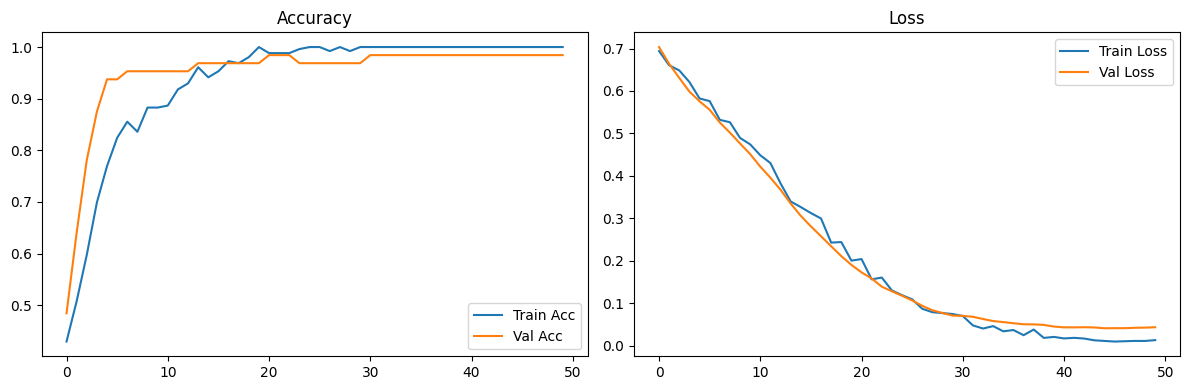

In [73]:
# Cell 11: Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.tight_layout(); plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Lower bound (perfect recall): 0.426
Upper bound (max F1):         0.566
Counts: {0: 6, 1: 55, 2: 3}


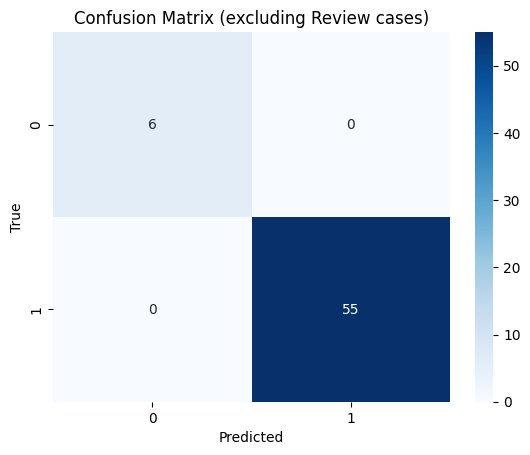

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00         6
        Fake       1.00      1.00      1.00        55

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61


Review zone: 3 samples (4.7% of test set)


In [83]:
# Cell 12: Three‐way decision with a “Review” zone

import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_curve

# 1) Load the best model & get probs
best    = tf.keras.models.load_model('best_model.h5')
y_prob  = best.predict(X_test)       # shape: (n,2)
y_true  = y_test.argmax(axis=1)      # 0=Real, 1=Fake

# 2) Compute your two thresholds
prec, rec, ths = precision_recall_curve(y_true, y_prob[:,1])
prec, rec = prec[:-1], rec[:-1]      # align with ths

#  - Max‐F1 threshold (thr_high)
f1s      = 2 * (prec * rec) / (prec + rec + 1e-8)
i_f1     = np.argmax(f1s)
thr_high = ths[i_f1]

#  - Perfect‐recall threshold (thr_low)
fake_probs = y_prob[y_true == 1, 1]
thr_low    = float(np.min(fake_probs))

print(f"Lower bound (perfect recall): {thr_low:.3f}")
print(f"Upper bound (max F1):         {thr_high:.3f}")

# 3) Apply three‐way decision
#    0=Real, 1=Fake, 2=Review
y_pred_three = []
for p in y_prob[:,1]:
    if p >= thr_high:
        y_pred_three.append(1)
    elif p < thr_low:
        y_pred_three.append(0)
    else:
        y_pred_three.append(2)
y_pred_three = np.array(y_pred_three)

# 4) Summary counts
from collections import Counter
counts = Counter(y_pred_three)
print("Counts:", {k: counts[k] for k in sorted(counts)})

# 5) Confusion matrix for the *hard* decisions only
#    We’ll treat “Review” as an abstention and ignore them in the hard‐label CM:
mask = (y_pred_three != 2)
cm = tf.math.confusion_matrix(y_true[mask], y_pred_three[mask], num_classes=2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix (excluding Review cases)')
plt.show()

# 6) Classification report on hard decisions
print(classification_report(
    y_true[mask], y_pred_three[mask],
    target_names=['Real','Fake']
))

# 7) How many were “Review”?
print(f"\nReview zone: {counts[2]} samples ({100*counts[2]/len(y_true):.1f}% of test set)")


In [84]:
# Cell 13: Save final model
best.save('deepfake_final_model.h5')
print("Saved to /kaggle/working/deepfake_final_model.h5")


Saved to /kaggle/working/deepfake_final_model.h5
